# Training and visualization

In this first tutorial we aim to show some basic functionality of our library. The main topics of this notebooks will be:
* visualization of a simple 2D dataset
* training classifiers with SecML
* visualization of the decision function of the trained classifiers

In [32]:
from collections import namedtuple
from math import ceil

from matplotlib.colors import ListedColormap

from secml.array import CArray
from secml.data.loader import CDLRandom, CDLRandomBlobs
from secml.data.splitter import CDataSplitter, CTrainTestSplit
from secml.figure import CFigure
from secml.ml.classifiers import CClassifierSVM, CClassifierDecisionTree, CClassifierKNN, CClassifierSGD
from secml.ml.classifiers.loss import CLossHinge
from secml.ml.classifiers.multiclass import CClassifierMulticlassOVA
from secml.ml.classifiers.regularizer import CRegularizerL2
from secml.ml.features import CNormalizerMinMax
from secml.ml.peval import CPerfEvaluatorXVal
from secml.ml.peval.metrics import CMetric

## Visualization of a simple 2D dataset

The first step is to load the dataset. 
We will load a simple dataset composed by 3 clusters of points 
normally distributed. We will use a 2D dataset because it is 
easier to visualize. The dataset will be splitted in training
and testing set, and normalized into the interval [0, 1] 
with a normalizer.

In [24]:
random_state = 999
n_classes = 3
n_features = 2
n_tr = 1000
n_ts = 250

dataset = CDLRandomBlobs(
    n_features=n_features, centers=n_classes, 
    n_samples=n_tr+n_ts).load()
splitter = CTrainTestSplit(train_size=n_tr, test_size=n_ts, random_state=random_state)
tr, ts = splitter.split(dataset)

# Normalize the data
nmz = CNormalizerMinMax()
tr.X = nmz.fit_transform(tr.X, tr.Y)
ts.X = nmz.transform(ts.X)

Now we can plot the samples in a 2D plane. 
The three clusters are clearly separable and 
normalized as we required.

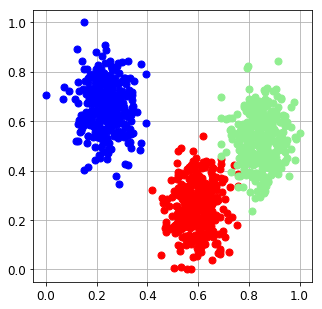

In [25]:
colors = ('red', 'blue', 'lightgreen', 'black', 'gray', 'cyan')
cmap = ListedColormap(colors[:n_classes])

fig = CFigure(width=5, height=5)
fig.sp.plot_ds(tr, cmap=cmap)
fig.show()

## Training classifiers with SecML

Now we can train a one-vs-all SVM with rbf kernel. 
We will evaluate the best parameters with a cross-validation,
selecting the best set based on the highest accuracy.

In [37]:
multiclass = CClassifierMulticlassOVA(
    CClassifierSVM, C=1, kernel='rbf')

xval_params = {'C': [1, 10, 100], 'kernel.gamma': [0.1, 1]}

xval_splitter = CDataSplitter.create(
    'kfold', num_folds=3, random_state=50000)
best_params = multiclass.estimate_parameters(
    tr, xval_params, xval_splitter, 'accuracy',
    perf_evaluator='xval-multiclass', n_jobs=1)

print(best_params)

# set best parameters and fit
multiclass.set_params(best_params)
multiclass.fit(tr)

perf_eval = CPerfEvaluatorXVal(
    xval_splitter, CMetric.create('accuracy'))
print(perf_eval.compute_performance(multiclass, tr))

{'C': (10, 1, 1), 'kernel.gamma': (1, 0.1, 0.1)}
0.99499799200398


## Visualization of the decision function of the trained classifiers

Once the classifier is trained, we can visualize the decision
function over the entire feature space. We can scatter the 
points belonging to the testing set in order to check how the 
classifiers behaves with unseen data.

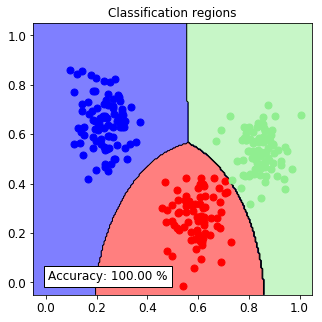

In [52]:
# plot decision function
colors = ('red', 'blue', 'lightgreen', 'black', 'gray', 'cyan')
cmap = ListedColormap(colors[:n_classes])

fig = CFigure(width=5, height=5)
fig.sp.plot_decision_function(multiclass, n_grid_points=200, cmap=cmap)
fig.sp.plot_ds(ts, cmap=cmap)
fig.sp.grid(grid_on=False)
fig.sp.title("Classification regions")

acc = CArray.mean(multiclass.predict(ts.X) == ts.Y)*100
fig.sp.text(0.01, 0.01, "Accuracy: %.2f %%" % acc, bbox=dict(facecolor='white'))
fig.show()

Now we can repeat the process with several 
classifiers in order to compare the results.
We can create a list containing the classifiers
along with the cross-validation parameters and 
other metadata (e.g. the classifier name). 

In [9]:
CLF = namedtuple('CLF', 'clf_name clf xval_parameters')
clf_list = [
    CLF(
        clf_name='SVM Linear',
        clf=CClassifierMulticlassOVA(CClassifierSVM, kernel='linear'),
        xval_parameters={'C': [1, 10, 100]}),
    CLF(clf_name='SVM Rbf',
        clf=CClassifierMulticlassOVA(CClassifierSVM, kernel='rbf'),
        xval_parameters={'C': [1, 10, 100], 'kernel.gamma': [0.1, 1]}),
    CLF(clf_name='KNN',
        clf=CClassifierMulticlassOVA(CClassifierKNN),
        xval_parameters={'n_neighbors': [1, 3, 5]}),
    CLF(clf_name='Decision Tree',
        clf=CClassifierMulticlassOVA(CClassifierDecisionTree),
        xval_parameters={'max_depth': [1, 3, 5]}),
    CLF(clf_name='SGD Linear',
        clf=CClassifierMulticlassOVA(CClassifierSGD, regularizer=CRegularizerL2(),
                                     loss=CLossHinge(), kernel='linear'),
        xval_parameters={'alpha': [0.01, 0.1, 1]}),
    CLF(clf_name='SGD RBF',
        clf=CClassifierMulticlassOVA(CClassifierSGD, regularizer=CRegularizerL2(),
                                     loss=CLossHinge(), kernel='rbf'),
        xval_parameters={'alpha': [0.01, 0.1, 1]}),
]

Lastly, a loop can help us generate a grid plot with the report 
of the list of classifiers. Again, we perform cross-validation for 
the optimization of the parameters. Finally, we plot the decision 
function of the classifiers and scatter the points belonging to 
the test set. 

Classifier:           SVM Linear	Accuracy:0.98
Classifier:              SVM Rbf	Accuracy:0.99
Classifier:                  KNN	Accuracy:0.99
Classifier:        Decision Tree	Accuracy:0.99
Classifier:           SGD Linear	Accuracy:0.98
Classifier:              SGD RBF	Accuracy:0.98


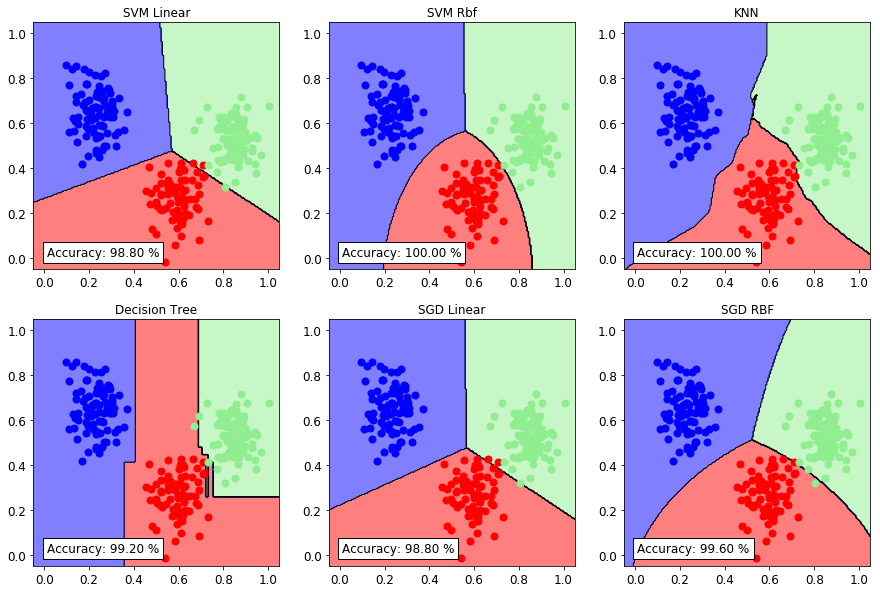

In [55]:
fig = CFigure(width=5 * len(clf_list)/2, height=5*2)

for clf_idx in range(len(clf_list)):
    clf = clf_list[clf_idx].clf
    xval_params = clf_list[clf_idx].xval_parameters
    xval_splitter = CDataSplitter.create(
        'kfold', num_folds=3, random_state=random_state)

    best_params = clf.estimate_parameters(
        tr, xval_params, xval_splitter, 'accuracy',
        perf_evaluator='xval-multiclass', n_jobs=1)

    # set best parameters and fit
    clf.set_params(best_params)
    clf.fit(tr)

    perf_eval = CPerfEvaluatorXVal(
        xval_splitter, CMetric.create('accuracy'))
    print("Classifier: %20s\tAccuracy:%.2f" % 
          (clf_list[clf_idx].clf_name, 
           perf_eval.compute_performance(clf, tr)))

    # plot decision function
    fig.subplot(2, int(ceil(len(clf_list)/2)), clf_idx + 1)
    fig.sp.title(clf_list[clf_idx].clf_name)
    fig.sp.plot_decision_function(clf, n_grid_points=200, cmap=cmap)
    fig.sp.plot_ds(ts, cmap=cmap)
    fig.sp.grid(grid_on=False)
    
    acc = CArray.mean(clf.predict(ts.X) == ts.Y)*100
    fig.sp.text(0.01, 0.01, "Accuracy: %.2f %%" % acc, bbox=dict(facecolor='white'))

fig.show()